# <center> Вводные данные <center/>
### Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Страховая компания хочет ответить на следующие вопросы, касающиеся страховых выплат:

+ В процессе своего анализа вы должны:

    * Выяснить, какие факторы влияют на зарплату специалиста Data Scientist. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
### Данные содержат следующие столбцы:

+ work_year - Год, в котором была выплачена зарплата.
+ experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
+ employment_type - Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
+ job_title - Роль, в которой соискатель работал в течение года.
+ salary - Общая выплаченная валовая сумма заработной платы.
+ salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
+ salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
+ employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
+ remote_ratio -Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
+ company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
+ company_size - Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

In [112]:
# подключение библиотек
import pandas as pd
import numpy as np

# разведывательный анализ данных
from ydata_profiling import ProfileReport

# создание категорий
import category_encoders as ce

# статистические тесты
import scipy.stats as stats

# графические библиотеки
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [113]:
# Функции
def outliers_iqr_mod(data, feature,left=1.5,right=1.5):
    """_Функция очистки данных от выбросов Тьюки_

    Args:
        data (_type_): _DataFrame_
        feature (_type_): _Имя ячейки_
        left (float, optional): _Левая граница_. Defaults to 1.5.
        right (float, optional): _Правая граница_. Defaults to 1.5.

    Returns:
        df: _cleaned -  очищенный DataFrame, outliers - DataFrame с выбросами_
    """    
    x = data[feature]                                             # создали serias 1 столбец
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),  # ищем QR1 QR3
    iqr = quartile_3 - quartile_1                                 # создали IQR
    lower_bound = quartile_1 - (iqr * left)                       # граница min
    upper_bound = quartile_3 + (iqr * right)                      # граница max
    outliers = data[(x < lower_bound) | (x > upper_bound)]        # все что вышло за границы
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]       # все что в границах
    return outliers, cleaned


# Функции кореляция
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix
    (I1,J1),
    (I2,J1),(I2,J2),
    (I3,J1),(I3,J2),(I3,J3),
    (I4,J1),(I4,J2),(I4,J3),(I4,J4)'''
    pairs_to_drop = set()                                # пустое множество
    cols = df.columns                                    # список с колонками
    for i in range(0, df.shape[1]):                      # перебор по колонкам
        for j in range(0, i+1):                          # перебор по колонкам ограничен I+1
            pairs_to_drop.add((cols[i], cols[j]))        # создаём множество множеств вариантов к колонкам для удаления
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()                  # кореляция.приводим к положительному.группировка
    labels_to_drop = get_redundant_pairs(df)             # функция
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False) # убираем повторы и сортируем
    return au_corr[0:n]                                  # вывод результата со срезом

# функция теста Шапиро — Уилка
def shap_uil(data,str_1=''):
    # проводим тест Шапиро — Уилка
    _, p = stats.shapiro(data)

    print('p-value = %.3f' % (p))

    # интерпретируем результат
    if p <= alpha:
        print('Распределение {} не нормальное'.format(str_1))
    else:
        print('Распределение {} нормальное'.format(str_1))
        
        
# функция теста Левена и запуск Шапиро — Уилка на 2 значения
def levin_2(data_1,data_2, str_1='', str_2=''):
    # проводим тест Левена на равенство дисперсий
    print('Тест на равенство дисперсий')
    result = stats.levene(data_1, data_2)
    p = result[1]
    print('p-value = {:.3f}'.format(p))

    # интерпретируем результат
    if p <= alpha:
        print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
    else:
        print('Дисперсии одинаковы, мы можем использовать тест Двухвыборочный t-критерий')
    
    # запуск Шапиро — Уилка
    shap_uil(data_1,str_1)
    shap_uil(data_2,str_2)
    
    # зададим параметры холста, название и визуализируем кривые распределения:
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
    ax1.set_title('Исходные распределения')

    # kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
    sns.kdeplot(data_1, ax=ax1, label =str_1)
    sns.kdeplot(data_2, ax=ax1, label =str_2)
    plt.legend()
        

# функция теста Левена и запуск Шапиро — Уилка на 3 значения
def levin_3(data_1,data_2, data_3, str_1='', str_2='', str_3=''):
    # проводим тест Левена на равенство дисперсий
    print('Тест на равенство дисперсий')
    result = stats.levene(data_1, data_2, data_3)
    p = result[1]
    print('p-value = {:.3f}'.format(p))

    # интерпретируем результат
    if p <= alpha:
        print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
    else:
        print('Дисперсии одинаковы, мы можем использовать тест ANOVA')
    
    # запуск Шапиро — Уилка
    shap_uil(data_1,str_1)
    shap_uil(data_2,str_2)
    shap_uil(data_3,str_3)
    
    # зададим параметры холста, название и визуализируем кривые распределения:
    fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
    ax1.set_title('Исходные распределения')

    # kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
    sns.kdeplot(data_1, ax=ax1, label =str_1)
    sns.kdeplot(data_2, ax=ax1, label =str_2)
    sns.kdeplot(data_3, ax=ax1, label =str_3)
    plt.legend()


In [114]:
# загрузка файла
data = pd.read_csv('data/ds_salaries.csv', index_col=[0])
# просмотр файла что подгрузится нормально
# display(data.head(3))
data.tail(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M
606,2022,MI,FT,AI Scientist,200000,USD,200000,IN,100,US,L


In [115]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

# Для отображения графиков на GitHub или интероктивость
git_bool = True # При выкладывании на GitHub нужно установить True

Уровень значимости alpha = 0.05


### Проводим иследование файла с помощью стандартных методов

In [116]:
print('Проверка пропусков')
display(data.isnull().sum()) # Проверка пропусков
print('Просмотор данных о файле')
display(data.info())         # Просмотр данных о файле
print('Индивидуальные значения')
data.nunique()               # просмотр количества индивидуальных значений в каждом столбце

Проверка пропусков


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Просмотор данных о файле
<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


None

Индивидуальные значения


work_year               3
experience_level        4
employment_type         4
job_title              50
salary                272
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

### Вывод
+ В датасете 607 записей
+ Пропуски отсутствуют
+ Числовые данные(4), категориальные данные(7)
* Разложить по количеству признаков категорий
    1. "work_year", "remote_ratio", "company_size" 3 признака, 
    2. "experience_level", "employment_type" 4 признака,
    3. "salary_currency"  17 признака

### Поиск и удаление дублекатов.

In [117]:
data_int=data.shape[0]                                 #начально значение строк
data=data.drop_duplicates()      #УДАЛЕНИЕ ДУБЛИКАТОВ и сохранение в новую переменную
print('копий удалось:',data_int-data.shape[0])    #(начальное значение)-(итоговое значение) 

копий удалось: 42


### Вывод
Было 42 копии и мы их удалили

In [118]:
data.describe().round(2)

,work_year,salary,salary_in_usd,remote_ratio
count,565.00,565.00,565.00,565.00
mean,2021.36,338115.99,110610.34,69.91
std,0.70,1599878.79,72280.70,40.90
min,2020.00,4000.00,2859.00,0.00
25%,2021.00,67000.00,60757.00,50.00
50%,2021.00,110925.00,100000.00,100.00
75%,2022.00,165000.00,150000.00,100.00
max,2022.00,30400000.00,600000.00,100.00


### Вывод
+ Имеется выброс в "salary", но зарплата в разной валюте "salary_currency" нужно привести к единой и посмотреть ещё раз.
+ Столбцы "salary" и "salary_currency" их можно удалить так как у нас имеется столбец "salary_in_usd" и он заменяет их

* Давайте поработаем с "salary" и "salary_currency" столбцы.
    + Проверим что зарплата в долларах соответствует "salary_in_usd"
    + Посмотрим в какой валюте где получают

Поработаем с "salary" в USD и "salary_currency" столбцы


,salary,salary_in_usd
1,260000,260000
3,20000,20000
4,150000,150000
5,72000,72000
6,190000,190000
...,...,...
602,154000,154000
603,126000,126000
604,129000,129000
605,150000,150000


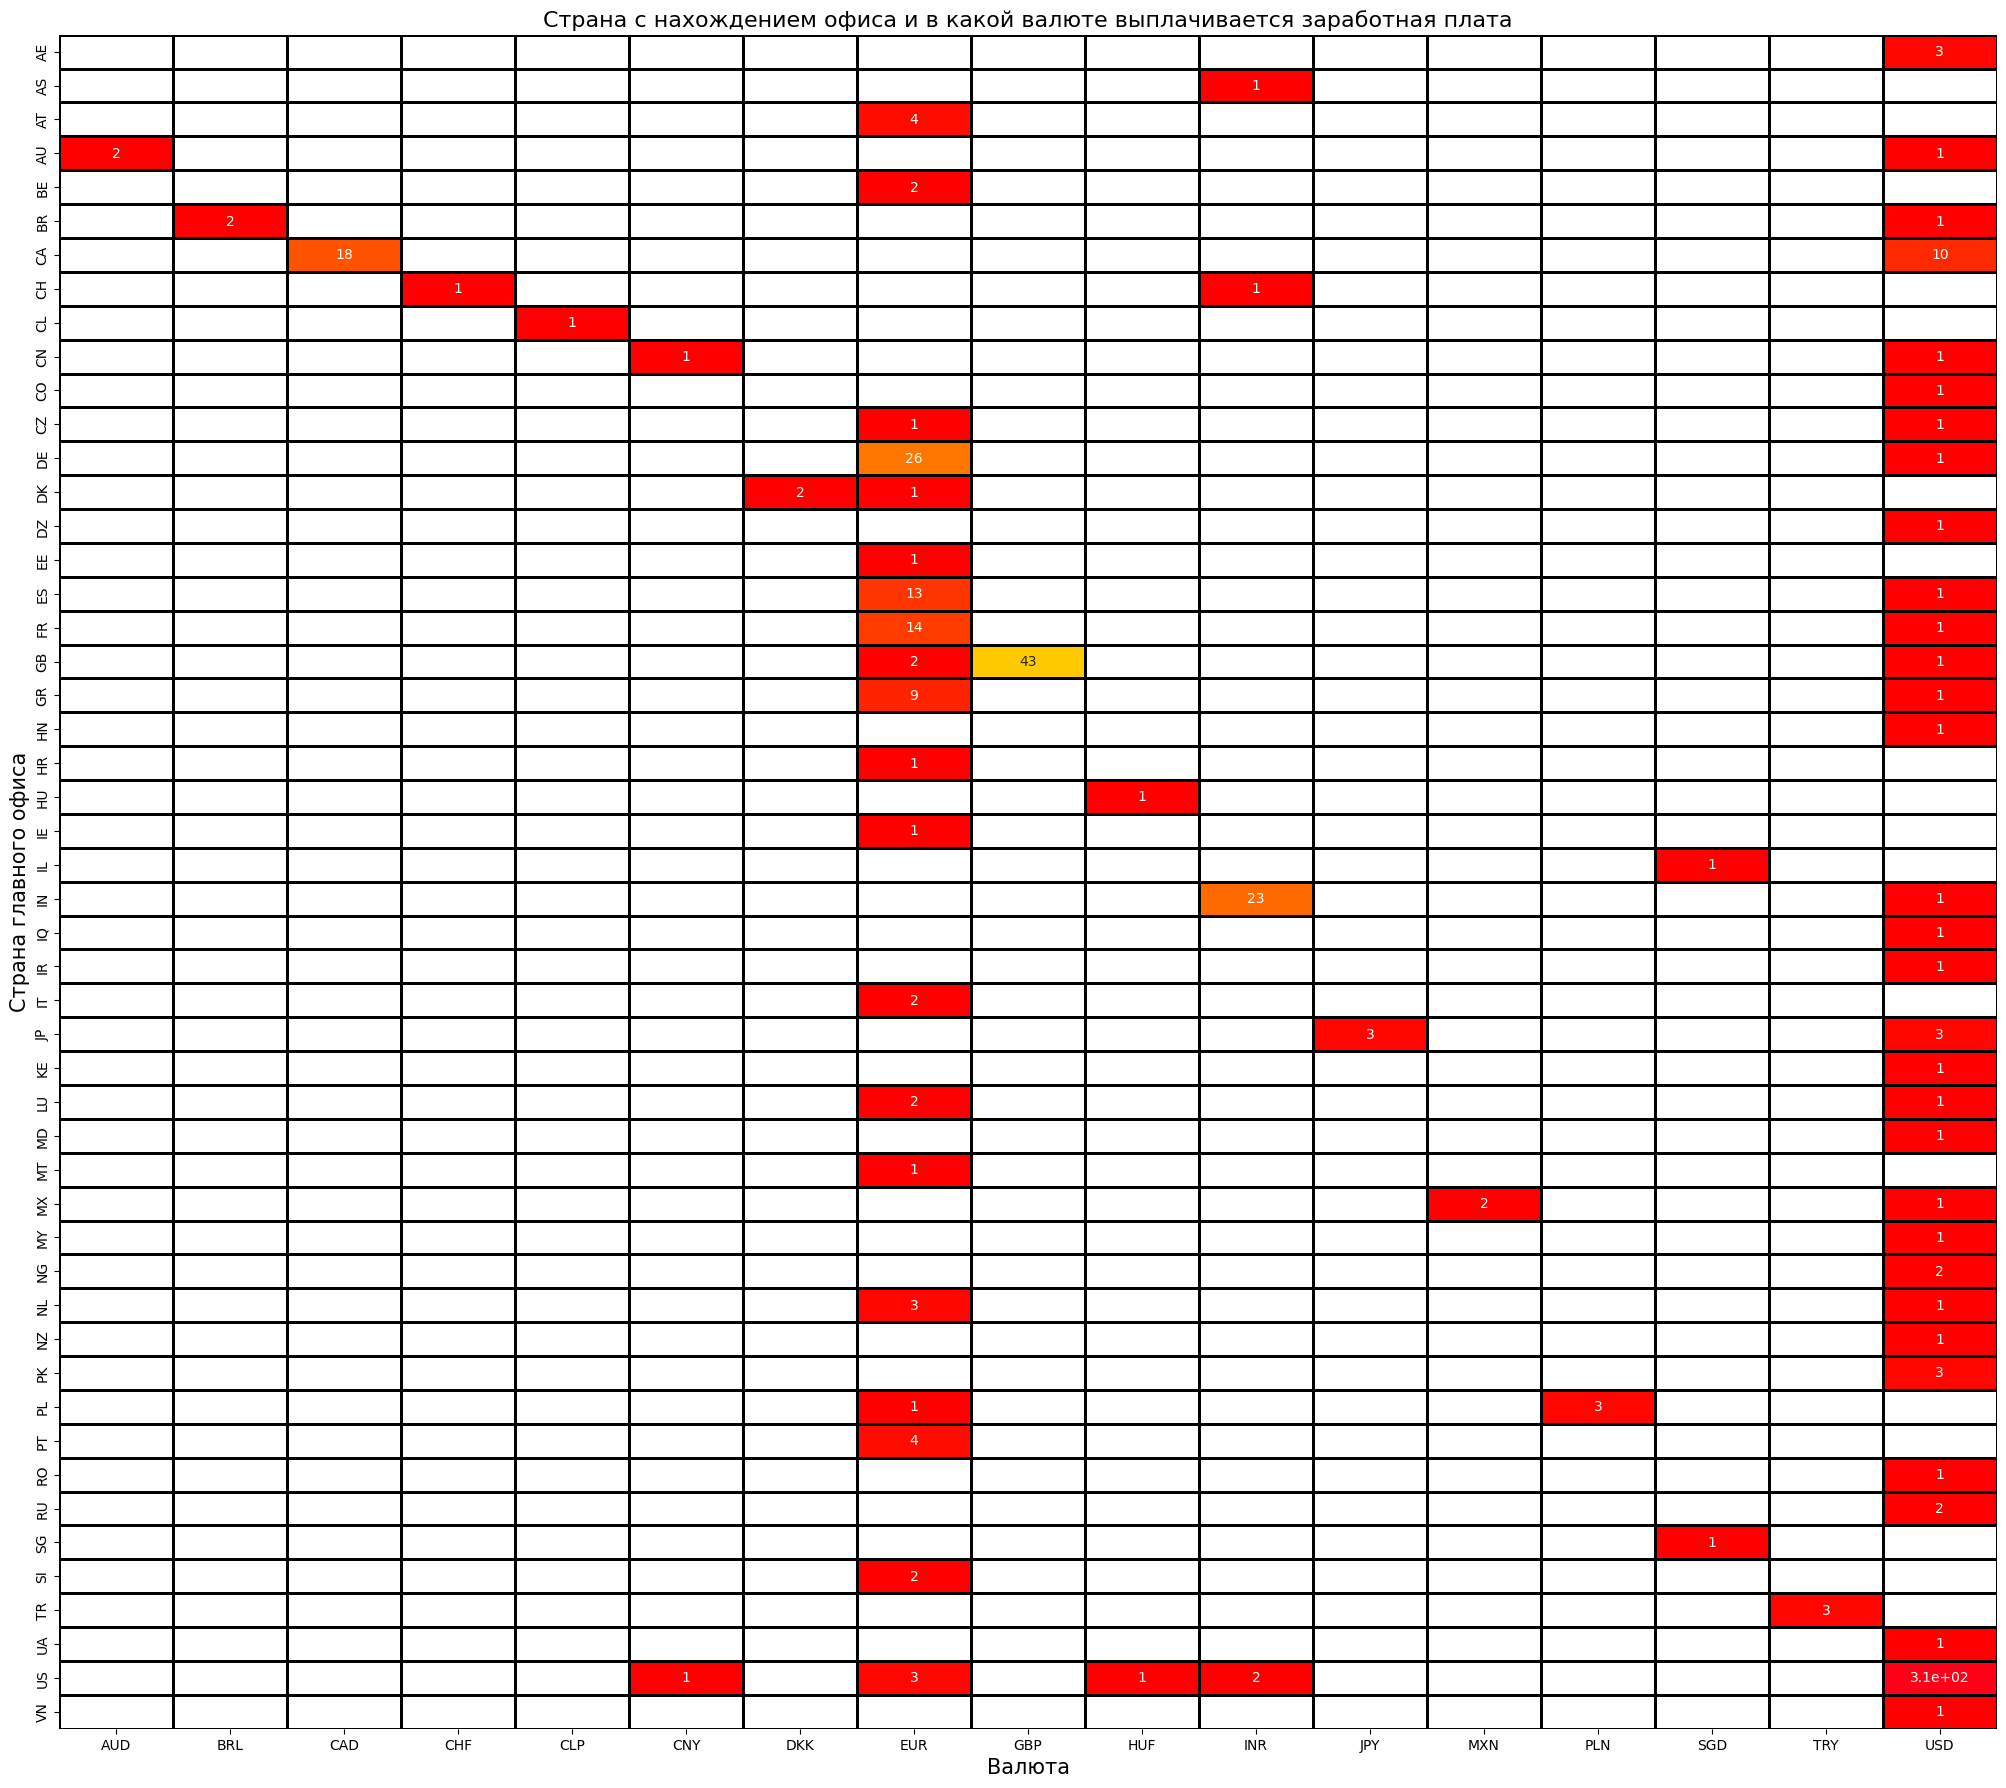

In [119]:
# data[data['employee_residence']!=str(data['salary_currency'])[:2]]

temp=data.pivot_table(
    values='work_year',   # Значения с которыми производим операции
    index= 'company_location', #'employee_residence',    # название строк и группировка по значению #company_location
    columns='salary_currency',   # название столбцов и группировка по значению
    aggfunc='count'      # функция по умолчанию mean()
    )

fig, (ax1) = plt.subplots(ncols=1, figsize=(25, 22)) # размер полотна
heatmap=sns.heatmap(temp, # df
            annot=True, # вывод надписей (подписать фон)
            cmap= 'hsv',    # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            linewidths=1, linecolor='black', # толщина и цвет окантовки ячеек
            cbar_kws= {'orientation': 'horizontal'},  # отображать цветовую шкалу горизонтально
            cbar=False,  # убрать цветовую шкалу
            
            )
# надписи на графике
plt.ylabel('Страна главного офиса', fontsize = 15)
plt.xlabel('Валюта', fontsize = 15)
heatmap.set_title('Страна с нахождением офиса и в какой валюте выплачивается заработная плата', fontsize=16);

print('Поработаем с "salary" в USD и "salary_currency" столбцы')
display(data[data['salary_currency']=='USD'][['salary','salary_in_usd']])

### Вывод
* Зарплата в долларах соответствует "salary_in_usd".
* В рублях зарплату никто не получает.
* В "US" получают зарплату в 5 разных валютах.
* B "GB" получают в большинстве в национальной валюте и в 2 других.
* "salary" и "salary_currency" столбцы больше не представляют интереса так как столбец "salary_in_usd" заменяет их.

### Продолжаем иследовать
посмотрим на файл с помощью "YDATA-PROFILING"

In [120]:
from ydata_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Очень интересный вывод
* Числовой признак 2, Категорийный признак 8, Текстовый 1.
    + Признаки "work_year" и "remote_ratio" относятся к категорийным так как имеют всего 3 значения.
    + Признаки "employee_residence" относятся к текстовой категоррии так как имеют 57 значений, надо оставить самые популярные
    + У признака "company_location" и "salary_currency" Сильная кореляция
    + У признака "salary" Сильная кореляция с признаками "salary_currency" и "salary_in_usd"
    + Распределение признаков не нормально

* А зарплату в рублях кто-нибудь получает?

In [121]:
#удаляем стобцы salary и salary_currency
data = data.drop(['salary','salary_currency'], axis= 1)

### Построим график, чтобы увидеть выбросы.

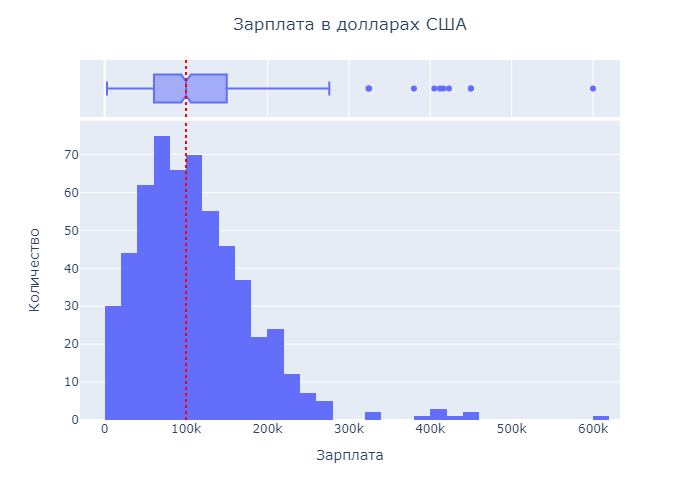

In [122]:
# Гистограмма
fig = px.histogram(
    data,
    x='salary_in_usd',
    marginal='box'
).update_layout( 
    title={"text": "Зарплата в долларах США", "x": 0.5},
    yaxis_title="Количество",xaxis_title='Зарплата'
)
fig.add_vline(x=data['salary_in_usd'].median(), line=dict(color="Red", width=2, dash="dot" ))

if git_bool :fig.show("png")
else: fig.show()

### Вывод
* Согласно графику у нас есть выбросы и если их отсечь будет похоже на нормальное рспределение или близко к этому.
* Основная доля зароботной платы у нас до 276к.
* Медианное значение зарплаты 100к

* Воспользуемся очисткой методом Тьюки

In [123]:
# Очистка данных методом Тьюки
outliers, cleaned = outliers_iqr_mod(data, 'salary_in_usd')  
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 10
Результирующее число записей: 555


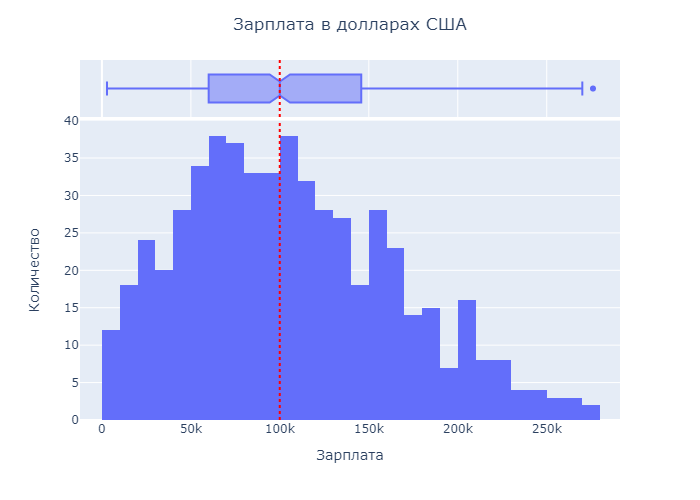

count       565.00
mean     110610.34
std       72280.70
min        2859.00
25%       60757.00
50%      100000.00
75%      150000.00
max      600000.00
Name: salary_in_usd, dtype: float64

In [124]:
# Гистограмма
fig = px.histogram(
    cleaned,
    x='salary_in_usd',
    marginal='box'
).update_layout( 
    title={"text": "Зарплата в долларах США", "x": 0.5},
    yaxis_title="Количество",xaxis_title='Зарплата'
)
fig.add_vline(x=cleaned['salary_in_usd'].median(), line=dict(color="Red", width=2, dash="dot" ))

if git_bool :fig.show("png")
else: fig.show()

data['salary_in_usd'].describe().round(2)

### Вывод
Методом Тьюки мы удалили 10 строк тем самым избавились от выбросов

## 1. Ответим на вопрос "Выяснить, какие факторы влияют на зарплату специалиста Data Scientist"
* Необходимо
    1. Из общего списка выделить специалистов Data Scientist.
    2. Закодируем признаки.
        + числовой ['remote_ratio','work_year']  можно привести к [1,2,3]
        + порядковые ['company_size','experience_level']
        + номинальные однократное кодирование ['employment_type']
        + номинальные двоекратное кодирование ['company_location','employee_residence']
    3. Посмотрим кареляцию.



employment_type_1   employment_type_2     0.813276
employee_residence  company_location      0.781431
salary_in_usd       experience_level      0.592070
employment_type_1   employment_type_3     0.572822
work_year           salary_in_usd         0.475819
salary_in_usd       employee_residence    0.452665
                    company_location      0.449531
work_year           experience_level      0.401989
                    employee_residence    0.337402
company_location    employment_type_2     0.333708
dtype: float64

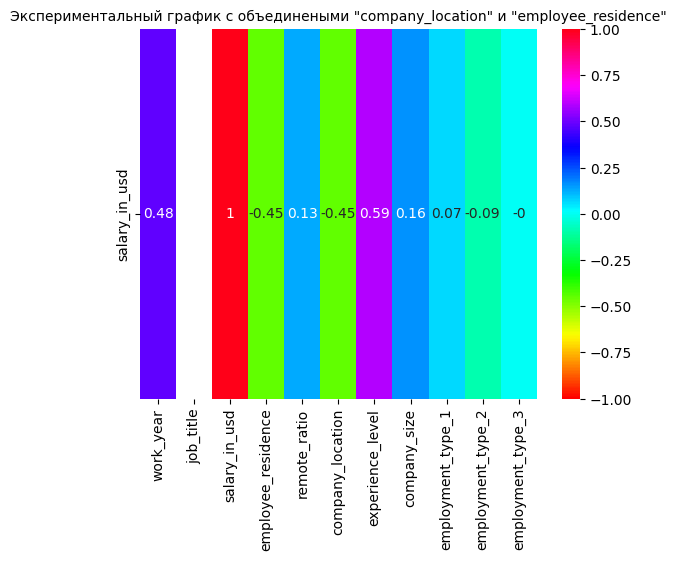

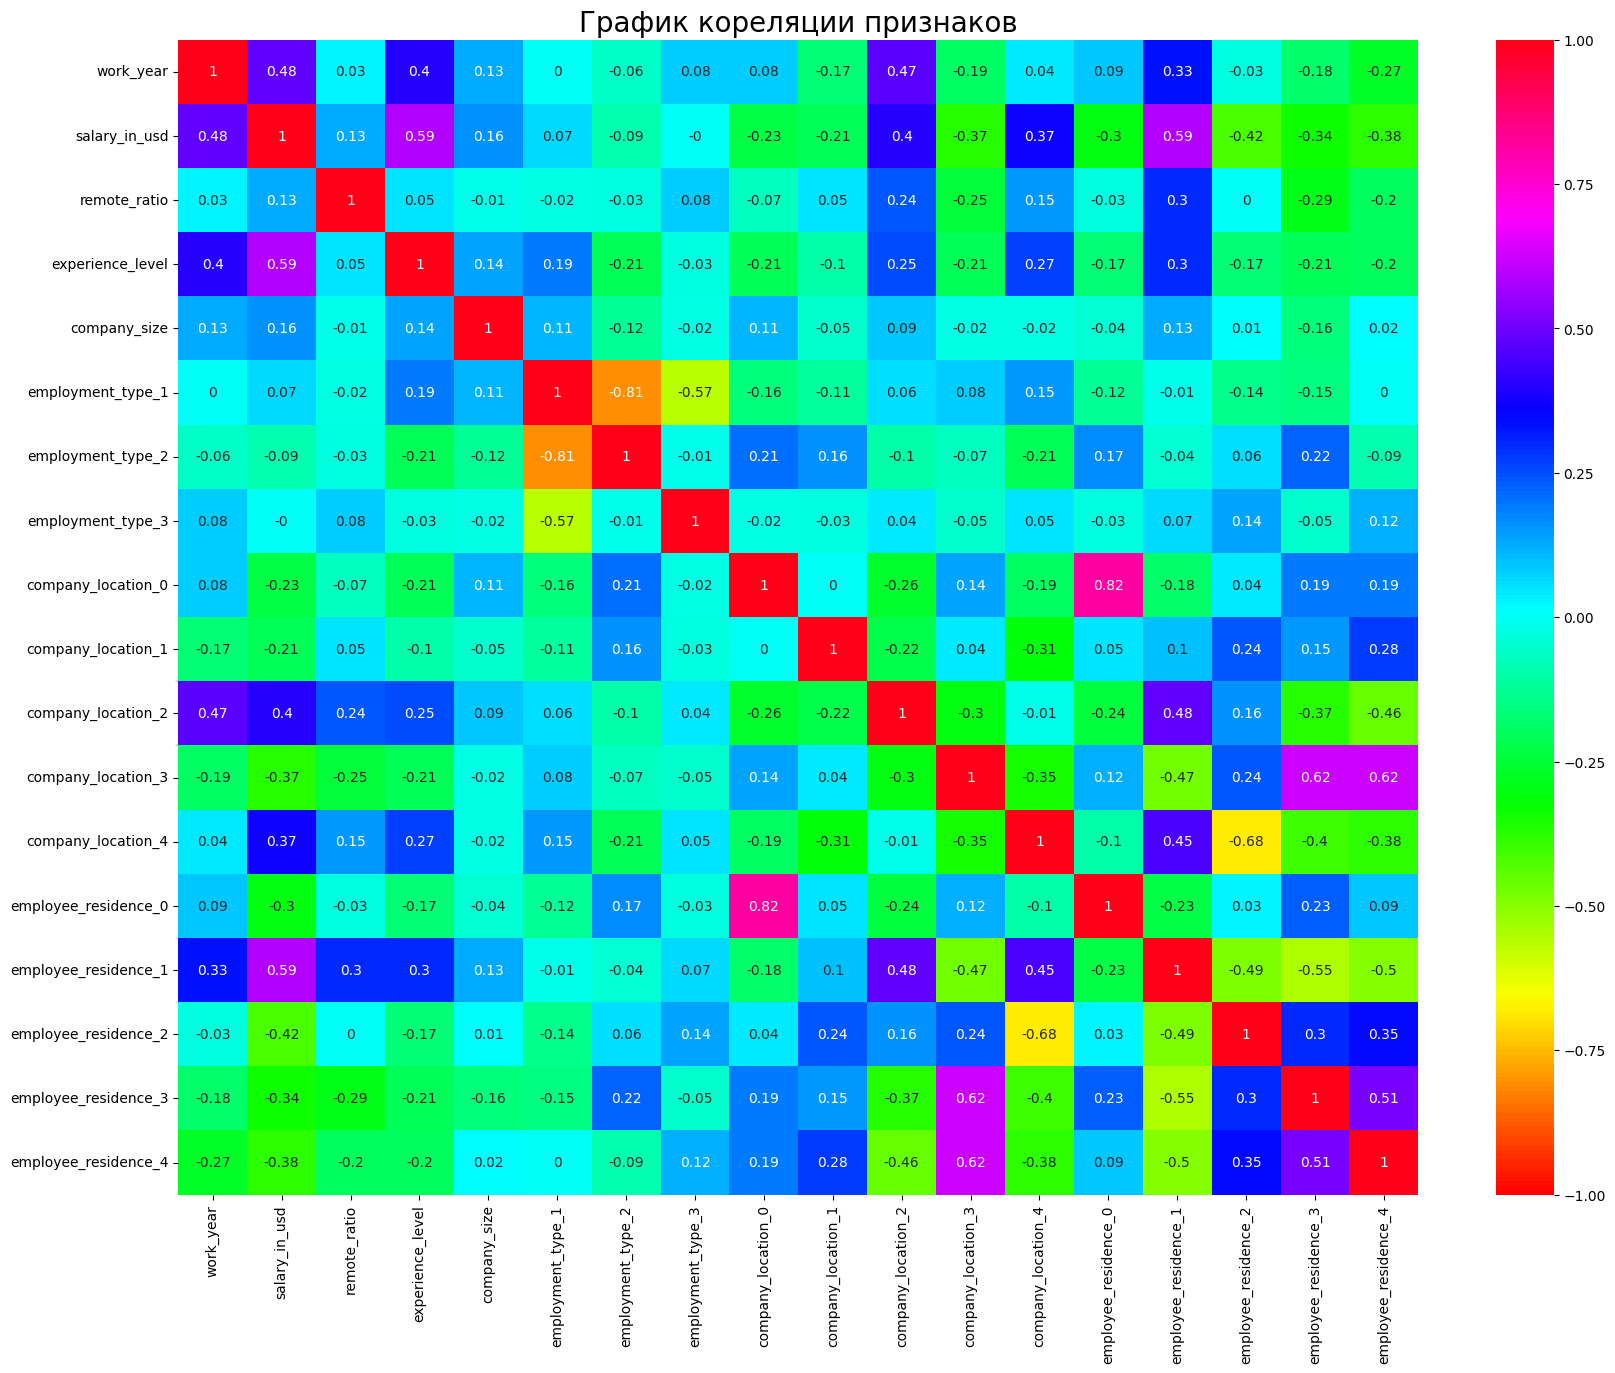

In [146]:
# Этап 1
temp_ds=cleaned[cleaned['job_title']=='Data Scientist'] # фильтр по 'Data Scientist'
# temp_c=cleaned.copy()
temp_c=temp_ds.copy()

# 2
# Создаём словари и списки для кодирования
list_set={ 'experience_level' : {'EN': 1, 'MI': 2, 'SE': 3, 'EX':4},
            'company_size' : {'S':1,'M':2,'L':3} }
list_OrdinalEncoder=['experience_level','company_size']
list_BinaryEncoder=['company_location','employee_residence']

# Этап 2.1
temp_c['work_year']=temp_c['work_year']-2019
temp_c['remote_ratio']=temp_c['remote_ratio']//50+1

# Этап 2.2
for index in list_OrdinalEncoder:
    # создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
    ord_encoder = ce.OrdinalEncoder(mapping=[{
	        'col': index,
	        'mapping': list_set[index]
            }])
    
    # применяем трансформацию к столбцу
    data_bin = ord_encoder.fit_transform(temp_c[index])
    # удаляем ячейки из исходного DataFrame
    temp_c=temp_c.drop(labels=index, axis=1)
    # добавляем результат к исходному DataFrame
    temp_c = pd.concat([temp_c, data_bin], axis=1)

# Этап 2.3

encoder = ce.OneHotEncoder(cols=['employment_type'], use_cat_names=False) # указываем столбец для кодирования

type_bin = encoder.fit_transform(temp_c['employment_type'])
# удаляем ячейки из исходного DataFrame
temp_c=temp_c.drop(labels='employment_type', axis=1)
# добавляем результат к исходному DataFrame
temp_c = pd.concat([temp_c, type_bin], axis=1)

# Этап 2.4
# ************************ эксперимент *********************
temp_exp=temp_c.copy()
for i in temp_exp.columns:                                # цикл перебора столбцов
    if temp_exp[i].dtypes == object :                     # определяем тип столбца и работаем только с object
        list_i=list(temp_exp[i].value_counts().index)     # создаем список с содержанием столбца по количеству повторений
        # заменяем текстовые признаки на числовые в столбцах содержащих >9 признаков последние объединяем
        temp_exp[i]=temp_exp[i].apply(lambda x: list_i.index(x)+1 )#if list_i.index(x) < 9 else 9) 
        
temp=temp_exp.corr(numeric_only=True).round(2)              # создаем таблицу кареляции
# График тепловая карта
sns.heatmap(temp.loc[['salary_in_usd'],::],                       # df
            annot=True,                 # вывод надписей (подписать фон)
            vmin=-1, vmax=1, center= 0, # границы тепловой шкалы
            cmap= 'hsv',                # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            # cbar_kws= {'orientation': 'horizontal'},  # отображать цветовую шкалу горизонтально
            ).set_title('Экспериментальный график с объединеными "company_location" и "employee_residence"', fontsize=10);     
# ************************ эксперимент *********************        

for index in list_BinaryEncoder:
    bin_encoder = ce.BinaryEncoder(cols=[index]) # указываем столбец для кодирования

    type_bin = bin_encoder.fit_transform(temp_c[index])
    # удаляем ячейки из исходного DataFrame
    temp_c=temp_c.drop(labels=index, axis=1)
    temp_c = pd.concat([temp_c, type_bin], axis=1)

# 3          
temp=temp_c.corr(numeric_only=True).round(2)              # создаем таблицу кареляции
# График тепловая карта
fig, (ax1) = plt.subplots(ncols=1, figsize=(20, 15))
sns.heatmap(temp,                       # df
            annot=True,                 # вывод надписей (подписать фон)
            vmin=-1, vmax=1, center= 0, # граници тепловой шкалы
            cmap= 'hsv',                # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            ).set_title('График кореляции признаков', fontsize=20);  

# Отыскание максимальной кореляции первые 10 значений
get_top_abs_correlations(temp_exp, 10)

### Вывод
* Признаки которые влияют на зарплату 
    + employee_residence
    + experience_level
    + work_year
    + company_location
* Но вывод делать рано надо посмотреть развернуто признаки

## 2.1. Oтветиv на вопрос "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist"

1. Создадим категорию года
2. Сгруппируем по годам со средними значениями

C:\Users\Temnykov\AppData\Local\Temp\ipykernel_7040\1945502479.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.05,33268.11,21669.0,41768.00,62726.0,94677.75,138350.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


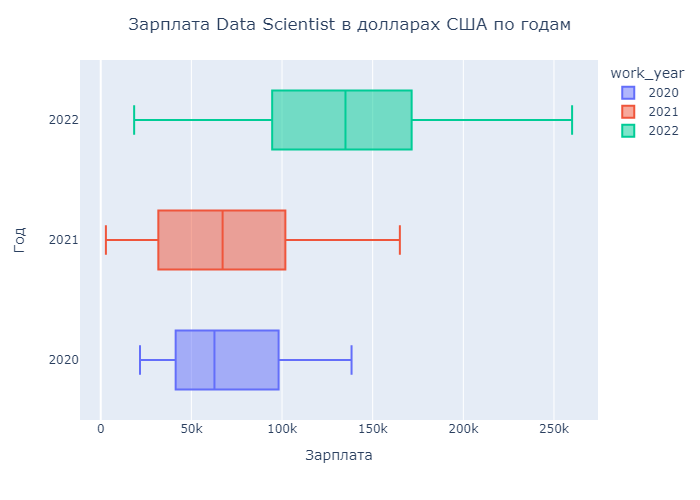

In [127]:
temp_ds['work_year']=temp_ds['work_year'].astype('category')

display(temp_ds.groupby('work_year')['salary_in_usd'].describe().round(2))

# Коробочная
fig = px.box(
    temp_ds,
    x='salary_in_usd',
    y='work_year',
    color='work_year'  
).update_layout( 
    title={"text": "Зарплата Data Scientist в долларах США по годам", "x": 0.5},
    yaxis_title="Год",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
* Мы наблюдаем ежегодный рост зарплат у специалистов Data Scientist это очень заметно на 2022г.
* Так же видим что средняя зарплата по 2020 и 2021 почти равны.
* Так же наблюдаем в 2021 самую минимальную зарплату (аномально низкая).

## Проведем статистический тест чтобы потвердить гипотезу

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
**Проверка на нормальность**        
С помощью теста Левена на равенство дисперсий. Напомним гипотезы теста Левена:        
*Нулевая гипотеза* ($H_0$): Нулевая гипотеза обоих тестов утверждает, что дисперсии групп равны.

Проведем сразу тест  Шапиро — Уилка
+ Нулевая: данные распределены нормально.
+ Альтернативная: данные не распределены нормально

Тест на равенство дисперсий
p-value = 0.040
Дисперсии не одинаковы, нужно использовать непараметрический тест
p-value = 0.145
Распределение 2020 нормальное
p-value = 0.107
Распределение 2021 нормальное
p-value = 0.676
Распределение 2022 нормальное


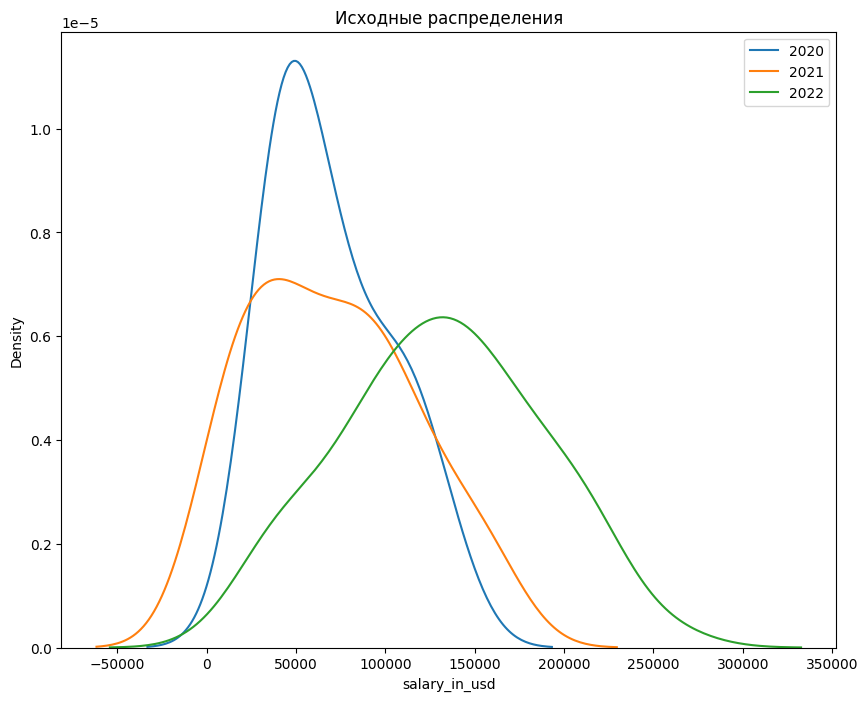

In [128]:
# Выборка данных
data_2020=temp_ds[temp_ds['work_year']==2020]['salary_in_usd']
data_2021=temp_ds[temp_ds['work_year']==2021]['salary_in_usd']
data_2022=temp_ds[temp_ds['work_year']==2022]['salary_in_usd']
# запуск функции тестов
levin_3(data_2020,data_2021, data_2022, '2020', '2021', '2022')

Выберем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Для этого ответим на следующие вопросы:
    + Какой тип у признака «Размер заработной платы»? — Количественный.
    + Сколько сравниваемых групп? — 3.
    + Группы зависимы? — Нет.
    + Признак распределён по нормальному закону? — Нет.
    
Чтобы проверить нашу гипотезу, можно использовать Критерий Краскела — Уоллиса.

**Сформулируем гипотезы в математическом виде:**
        
*Нулевая гипотеза* ($H_0$): размер зарплаты года 2020 ($μ_1$), размер зарплаты года 2021 ($μ_2$) и размер зарплаты года 2022 ($μ_3$) одинаковы.
        
$$H_0 : μ_1 = μ_2 = μ_3$$
        
*Альтернативная гипотеза* размер зарплаты года 2020 ($μ_1$), размер зарплаты года 2021 ($μ_2$) и размер зарплаты года 2022 ($μ_3$) не одинаковые.
        
$$ H_1 : μ_1 != μ_2 != μ_3$$

In [129]:
# проводим тест
_, p = stats.kruskal(data_2020, data_2021, data_2022)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Вывод
Отвергаем нулевую гипотезу, значит  можно утверждать что зарплаты не равны.

И происходит уменьшение или увеличение зарплаты, а исходя из графиков можно сказать что наблюдается ежегодный рост заработной платы.

### Итого
Можно сделать вывод что данные не опровергают ежегодный рост заработной платы

## 2.2. Ответим на вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?"


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,78.0,122096.04,53544.36,25000.0,78526.0,114000.0,160000.0,243900.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


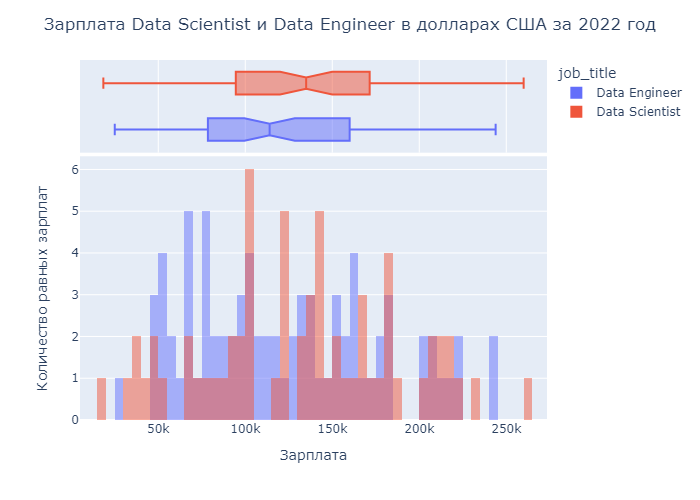

In [130]:
temp_ds_de=cleaned[cleaned['job_title'].isin(['Data Scientist','Data Engineer'])] # фильтр по 'Data Scientist' и 'Data Engineer'
temp=temp_ds_de[temp_ds_de['work_year']==2022]
display(temp.groupby('job_title')['salary_in_usd'].describe().round(2))

fig = px.histogram(
    temp,
    x='salary_in_usd',
    # y='job_title',
    color='job_title',
    nbins=50,
    # barmode='stack',
    barmode='overlay',
    # barmode= 'group',
    marginal='box'  
).update_layout( 
    title={"text": "Зарплата Data Scientist и Data Engineer в долларах США за 2022 год", "x": 0.5},
    yaxis_title="Количество равных зарплат",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
* Зарплата Data Scientist по сравнению с Data Engineer имеет больший размах в сторону минимального и максимального значения (очень похожа на выбросы).
* Средняя значение зарплата у Data Scientist больше на 9000 чем Data Engineer.
* Но медианное значение зарплата у Data Scientist уже больше на 21000 чем Data Engineer, так как Data Scientist.

Из того можем предположить что Data Scientist зарабатывают больше по отношению к Data Engineer.

## Проведем статистический тест чтобы потвердить гипотезу
### Зарплата у Data Scientist больше по сравнению с зарплатой у Data Engineer?
**Проверка на нормальность**
С помощью теста Левена на равенство дисперсий. Напомним гипотезы теста Левена:        
+ *Нулевая гипотеза* ($H_0$): Нулевая гипотеза обоих тестов утверждает, что дисперсии групп равны.

Проведем сразу тест  Шапиро — Уилка
+ Нулевая: данные распределены нормально.
+ Альтернативная: данные не распределены нормально


Тест на равенство дисперсий
p-value = 0.929
Дисперсии одинаковы, мы можем использовать тест Двухвыборочный t-критерий
p-value = 0.676
Распределение Data Scientist нормальное
p-value = 0.021
Распределение Data Engineer не нормальное


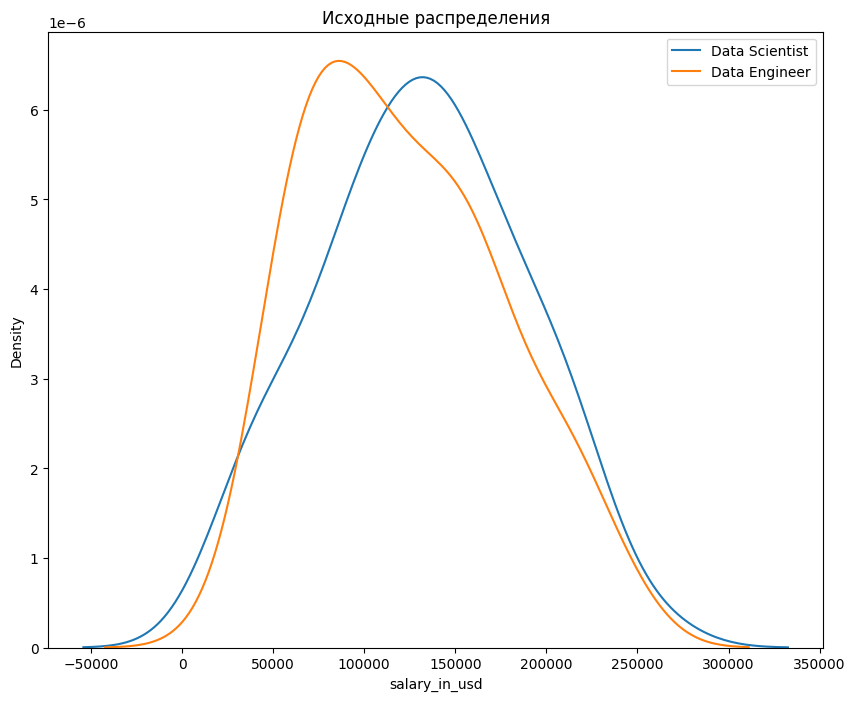

In [131]:
temp_ds=cleaned[cleaned['job_title']=='Data Scientist'] # фильтр по 'Data Scientist'
temp_de=cleaned[cleaned['job_title']=='Data Engineer'] # фильтр по 'Data Engineer'ArithmeticError
temp_ds_22=temp_ds[temp_ds['work_year']==2022]['salary_in_usd']
temp_de_22=temp_de[temp_de['work_year']==2022]['salary_in_usd']

# запуск функции тестов
levin_2(temp_ds_22, temp_de_22, 'Data Scientist', 'Data Engineer')

Выберем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Для этого ответим на следующие вопросы:
    + Какой тип у признака «Размер заработной платы»? — Количественный.
    + Сколько сравниваемых групп? — 2.
    + Группы зависимы? — Нет.
    + Признак распределён по нормальному закону? — Нет.
    
Чтобы проверить нашу гипотезу, можно использовать U-КРИТЕРИЙ МАННА — УИТНИ.
**Сформулируем гипотезы в математическом виде:**        
*Нулевая гипотеза* ($H_0$): размер зарплаты Data Engineer ($μ_1$) и размер зарплаты Data Scientist ($μ_2$) одинаковы.        
$$H_0 : μ_1 = μ_2$$        
*Альтернативная гипотеза* размер зарплаты Data Engineer ($μ_1$) и размер зарплаты Data Scientist ($μ_2$) не одинаковы.        
$$ H_1 : μ_1 != μ_2$$

In [132]:
# проводим тест
_, p = stats.mannwhitneyu(temp_ds_22, temp_de_22)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.255
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод
Отвергаем альтернативную гипотезу, значит можно утверждать что зарплаты равны.

### Итого
Данные отвергают что зарплаты Data Scientist и Data Engineer не одинаковы

## 2.3. Ответим на вопрос "Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?"

* S — менее 50 сотрудников (небольшая компания);
* M — от 50 до 250 сотрудников (средняя компания);
* L — более 250 сотрудников (крупная компания).

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Крупная компания,42.0,95380.17,55756.89,13400.0,42860.75,89694.0,133750.0,215300.0
Средняя компания,66.0,120080.58,56347.79,4000.0,80000.00,119529.5,157500.0,260000.0
Небольшая компания,21.0,51925.76,33216.29,2859.0,21669.00,49268.0,82500.0,105000.0


Крупная компания зарабатывает 79% от Средняя компания
Небольшая компания зарабатывает 43% от Средняя компания


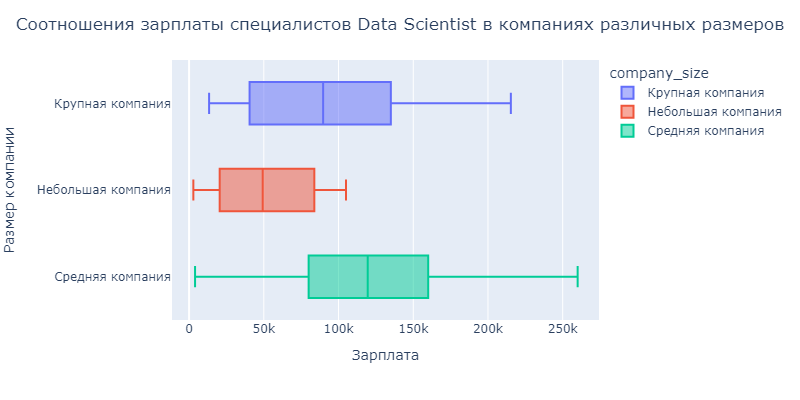

In [133]:
temp_ds_cat=cleaned[cleaned['job_title']=='Data Scientist'].copy()
#  создадим категории 
temp_ds_cat['company_size']=temp_ds_cat['company_size'].astype('category')
temp_ds_cat['company_size']=temp_ds_cat['company_size'].cat.rename_categories({'S':'Небольшая компания', 'M': 'Средняя компания','L':'Крупная компания'})

display(temp_ds_cat.groupby('company_size')['salary_in_usd'].describe().round(2))

# найдем соотношение зарплат
# словарь размер компании: медианная зарплата в компании
temp_dict={'Небольшая компания':temp_ds_cat[temp_ds_cat['company_size']=='Небольшая компания']['salary_in_usd'].mean(),
      'Средняя компания':temp_ds_cat[temp_ds_cat['company_size']=='Средняя компания']['salary_in_usd'].mean(),
      'Крупная компания':temp_ds_cat[temp_ds_cat['company_size']=='Крупная компания']['salary_in_usd'].mean()}
# список компаний отсортированый по зарплате
temp_list=sorted(temp_dict, key=temp_dict.get, reverse=True)

tepm_1=100/temp_dict[temp_list[0]]
# цикл вывода процентного соотношения
for i in range(len(temp_list)-1):
    print('{0} зарабатывает {1}% от {2}'.format(temp_list[i+1], round(tepm_1*temp_dict[temp_list[i+1]]) ,temp_list[0]))

fig = px.box(
    temp_ds_cat,
    x='salary_in_usd',
    y='company_size',
    color='company_size', 
    width=800, height=400
).update_layout( 
    title={"text": "Cоотношения зарплаты специалистов Data Scientist в компаниях различных размеров", "x": 0.5},
    yaxis_title="Размер компании",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
* В крупная компания минимальна зароботная плата от 13000, остальные показатели у крупной компании меньше показателей среднии компании.
* Лидером по высокой зарплате являются среднии компании.
* Соотношение зарплат
    + Зарплата в крупной компании 79% от зарплаты в средней компании
    + Зарплата в небольшая компания 43% от зарплаты в средней компании

## Проведем статистический тест чтобы потвердить гипотезу
### Соотношение зарплаты в компаниях среднего размера выше зарплат кпупных компаний?
**Проверка на нормальность**
С помощью теста Левена на равенство дисперсий. Напомним гипотезы теста Левена:        
+ *Нулевая гипотеза* ($H_0$): Нулевая гипотеза обоих тестов утверждает, что дисперсии групп равны.

Проведем сразу тест  Шапиро — Уилка
+ Нулевая: данные распределены нормально.
+ Альтернативная: данные не распределены нормально

Тест на равенство дисперсий
p-value = 0.825
Дисперсии одинаковы, мы можем использовать тест Двухвыборочный t-критерий
p-value = 0.897
Распределение Средняя компания нормальное
p-value = 0.030
Распределение Крупная компания не нормальное


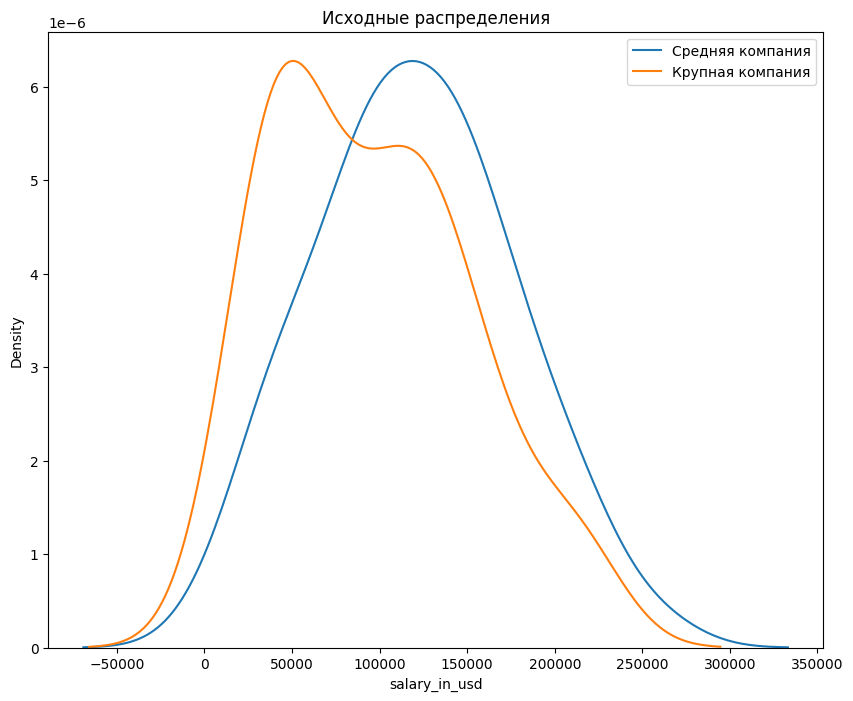

In [134]:
temp_m=temp_ds_cat[temp_ds_cat['company_size']=='Средняя компания']['salary_in_usd']
temp_l=temp_ds_cat[temp_ds_cat['company_size']=='Крупная компания']['salary_in_usd']

# запуск функции тестов
levin_2(temp_m, temp_l, 'Средняя компания', 'Крупная компания')

Выберем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Для этого ответим на следующие вопросы:
    + Какой тип у признака «Размер заработной платы»? — Количественный.
    + Сколько сравниваемых групп? — 2.
    + Группы зависимы? — Нет.
    + Признак распределён по нормальному закону? — Нет.
    
Чтобы проверить нашу гипотезу, можно использовать U-КРИТЕРИЙ МАННА — УИТНИ.
**Сформулируем гипотезы в математическом виде:**        
*Нулевая гипотеза* ($H_0$): размер зарплаты в средней компании ($μ_1$) и размер зарплаты крупной компании ($μ_2$) одинаковы.        
$$H_0 : μ_1 = μ_2$$        
*Альтернативная гипотеза* размер зарплаты в средней компании ($μ_1$) и размер зарплаты крупной компании ($μ_2$) не одинаковы.        
$$ H_1 : μ_1 != μ_2$$

In [135]:
# проводим тест
_, p = stats.mannwhitneyu(temp_m, temp_l)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.027
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Выводы
Отвергаем нулевую гипотезу и принимаем альтернативную гипотезу

Из этого делаем вывод что самая высокая зарплата в средних компаниях.
* Соотношение зарплат
    + Зарплата в крупной компании 79% от зарплаты в средней компании
    + Зарплата в небольшая компания 43% от зарплаты в средней компании

### Проверим соотношение зарплат и место расположения компании и их размер

Топ стран компаний по зарплате
Крупная компания ['US', 'CH', 'GB']
Средняя компания ['US', 'IL', 'DZ']
Небольшая компания ['AT', 'CA', 'GB']


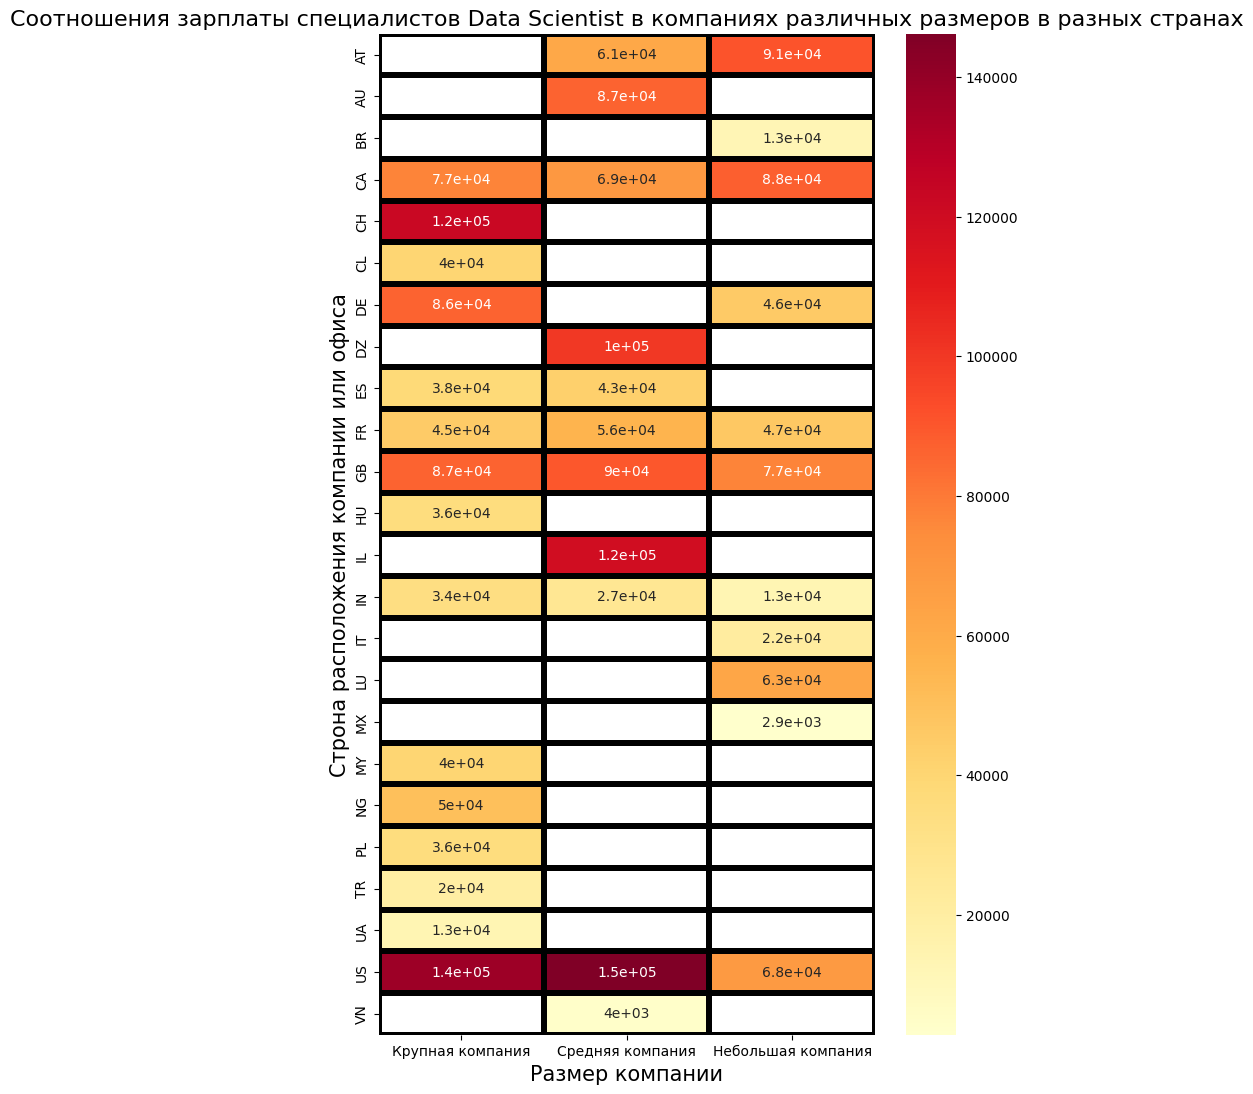

In [136]:
temp=temp_ds_cat.pivot_table(
    values='salary_in_usd',   # Значения с которыми производим операции
    index= 'company_location',    # название строк и группировка по значению
    columns= 'company_size',   # название столбцов и группировка по значению
    aggfunc='mean'      # функция по умолчанию mean()
    )
print('Топ стран компаний по зарплате')
print('Крупная компания',list(temp['Крупная компания'].sort_values(ascending=False).head(3).index))
print('Средняя компания',list(temp['Средняя компания'].sort_values(ascending=False).head(3).index))
print('Небольшая компания',list(temp['Небольшая компания'].sort_values(ascending=False).head(3).index))

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 13))
heatmap=sns.heatmap(temp, # df
            annot=True, # вывод надписей (подписать фон)
            cmap= 'YlOrRd',    # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            linewidths=3, linecolor='black', # толщина и цвет оконтовки ячеек
            # cbar_kws= {'orientation': 'horizontal'},  # отображать цветовую шкалу горизонтально
            # cbar=False,  # убрать цветовую шкалу
            # square=True    # форма ячеек квадрат
            # mask=filtr_1  # фильтр выводимых значений
            )
plt.xlabel('Размер компании', fontsize = 15)
plt.ylabel('Строна расположения компании или офиса', fontsize = 15)
heatmap.set_title('Cоотношения зарплаты специалистов Data Scientist в компаниях различных размеров в разных странах', fontsize=16);

### Вывод
* Крупные компании расположены в большинстве стран
* В "US" средних и крупных компаниях наблюдается самая высокая зарплата

## 2.4. Ответим на вопрос "Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?"

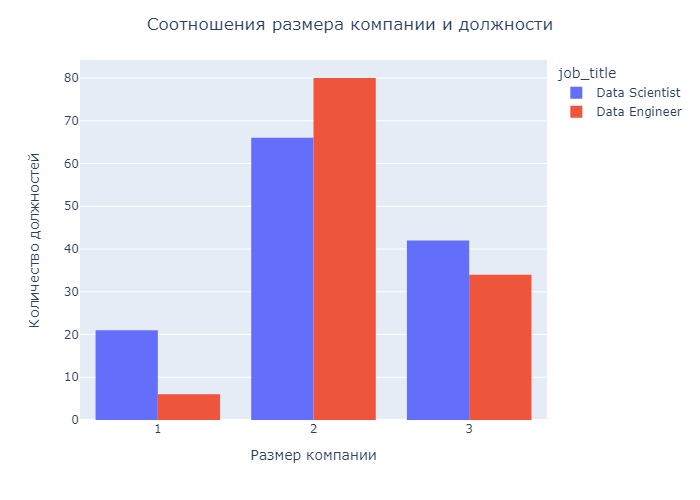

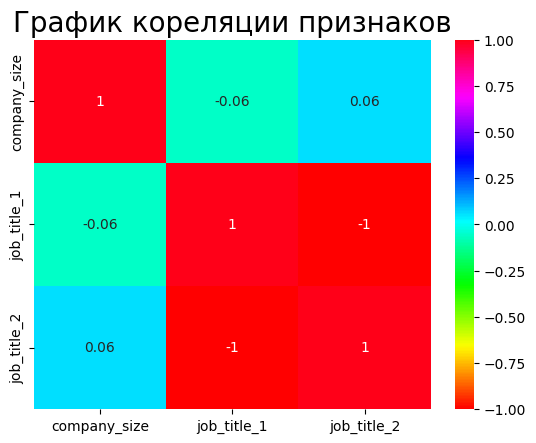

In [137]:
temp_c=temp_ds_de[['company_size','job_title']].copy()
# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	        'col': 'company_size',
	        'mapping': {'S':1,'M':2,'L':3}
            }])
    
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(temp_c['company_size'])
# удаляем ячейки из исходного DataFrame
temp_c=temp_c.drop(labels='company_size', axis=1)
# добавляем результат к исходному DataFrame
temp_c = pd.concat([temp_c, data_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['job_title'], use_cat_names=False) # указываем столбец для кодирования

type_bin = encoder.fit_transform(temp_c['job_title'])
# удаляем ячейки из исходного DataFrame
temp_ca=temp_c.drop(labels='job_title', axis=1)
# добавляем результат к исходному DataFrame
temp_ca = pd.concat([temp_ca, type_bin], axis=1)

temp=temp_ca.corr(numeric_only=True).round(2)              # создаем таблицу кареляции
# График тепловая карта
sns.heatmap(temp,                       # df
            annot=True,                 # вывод надписей (подписать фон)
            vmin=-1, vmax=1, center= 0, # границы тепловой шкалы
            cmap= 'hsv',                # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            ).set_title('График кореляции признаков', fontsize=20); 

fig=px.histogram(
    temp_c,
    x='company_size',
    color='job_title',
    barmode='group'
).update_layout( 
    title={"text": "Cоотношения размера компании и должности", "x": 0.5},
    yaxis_title='Количество должностей',xaxis_title='Размер компании'
)
# fig.update_xaxes( labelalias=dict(1="Суббота", 2="Воскресенье",3="Суббот"))
if git_bool :fig.show("png")
else: fig.show()

### Вывод
На графике зависимости не видно

### Проверим как влияет опыта работы на зарплату 

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,48.0,145267.33,50597.67,20171.0,104843.0,142200.0,180000.00,260000.0


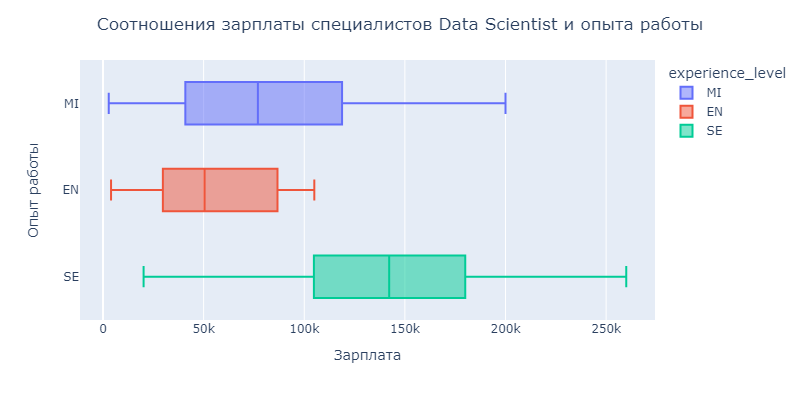

In [138]:
display(temp_ds.groupby('experience_level')['salary_in_usd'].describe().round(2))

fig = px.box(
    temp_ds,
    x='salary_in_usd',
    y='experience_level',
    color='experience_level', 
    width=800, height=400
).update_layout( 
    title={"text": "Cоотношения зарплаты специалистов Data Scientist и опыта работы", "x": 0.5},
    yaxis_title="Опыт работы",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
Заметно влияние опыта работы на зарплату с опытом работы зарплата становится больше.

## Проведем статистический тест чтобы потвердить гипотезу
### Соотношение зарплаты в компаниях среднего размера выше зарплат кпупных компаний?
**Проверка на нормальность**
С помощью теста Левена на равенство дисперсий. Напомним гипотезы теста Левена:        
+ *Нулевая гипотеза* ($H_0$): Нулевая гипотеза обоих тестов утверждает, что дисперсии групп равны.

Проведем сразу тест  Шапиро — Уилка
+ Нулевая: данные распределены нормально.
+ Альтернативная: данные не распределены нормально

Тест на равенство дисперсий
p-value = 0.071
Дисперсии одинаковы, мы можем использовать тест ANOVA
p-value = 0.146
Распределение MI нормальное
p-value = 0.174
Распределение EN нормальное
p-value = 0.981
Распределение SE нормальное


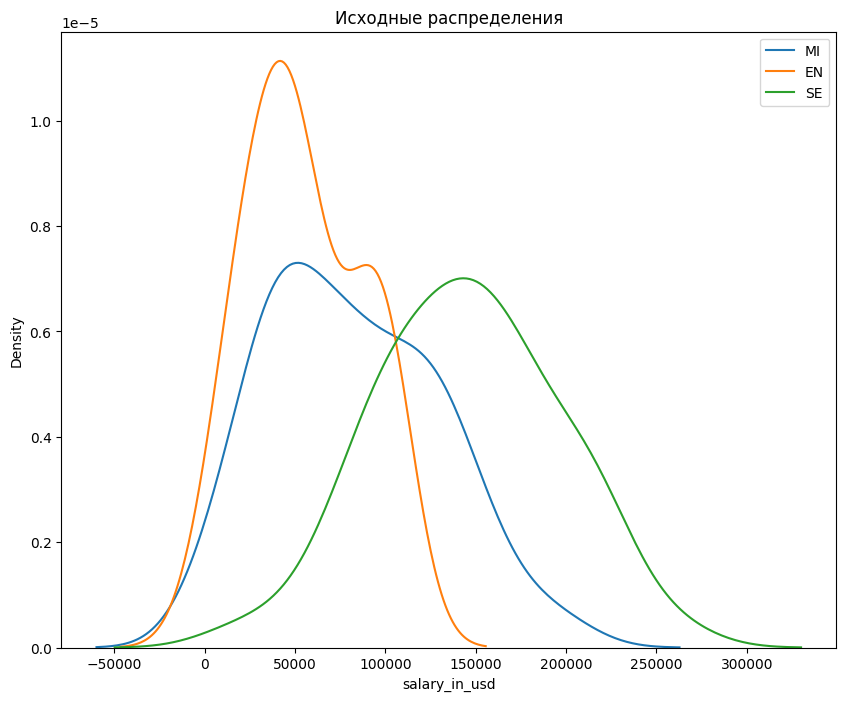

In [139]:
temp_mi=temp_ds[temp_ds['experience_level']=='MI']['salary_in_usd']
temp_en=temp_ds[temp_ds['experience_level']=='EN']['salary_in_usd']
temp_se=temp_ds[temp_ds['experience_level']=='SE']['salary_in_usd']

# запуск функции тестов
levin_3(temp_mi, temp_en, temp_se, 'MI', 'EN', 'SE')

Выберем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Для этого ответим на следующие вопросы:
    + Какой тип у признака «Размер заработной платы»? — Количественный.
    + Сколько сравниваемых групп? — 3.
    + Группы зависимы? — Нет.
    + Признак распределён по нормальному закону? — да.
    
Чтобы проверить нашу гипотезу, Однофакторный дисперсионный анализ (ANOVA).
**Сформулируем гипотезы в математическом виде:**        
*Нулевая гипотеза* ($H_0$): размер зарплаты со стажем MI ($μ_1$), размер зарплаты со стажем EN ($μ_2$) и размер зарплаты со стажем SE ($μ_3$) одинаковы.        
$$H_0 : μ_1 = μ_2 = μ_3$$        
*Альтернативная гипотеза* размер зарплаты со стажем MI ($μ_1$), размер зарплаты со стажем EN ($μ_2$) и размер зарплаты со стажем SE ($μ_3$) не одинаковое.        
$$ H_1 : μ_1 != μ_2 != μ_3$$


In [140]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.f_oneway(temp_mi, temp_en, temp_se)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### Вывод
Отвергаем нулевую гипотизу и принимаем альтернативную в неравенстве зарплат в зависимости от стажа работы.

Делаем вывод у нас нет оснований отвергать выводы сделанные из графиков что зарплата растет с опытом работы.
### Итог
Зарплата растет с опытом работы.

### Проверим как влияия тип трудоустройства на зарплату

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,126.0,101587.75,58343.68,2859.0,50330.25,99680.0,140400.00,260000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


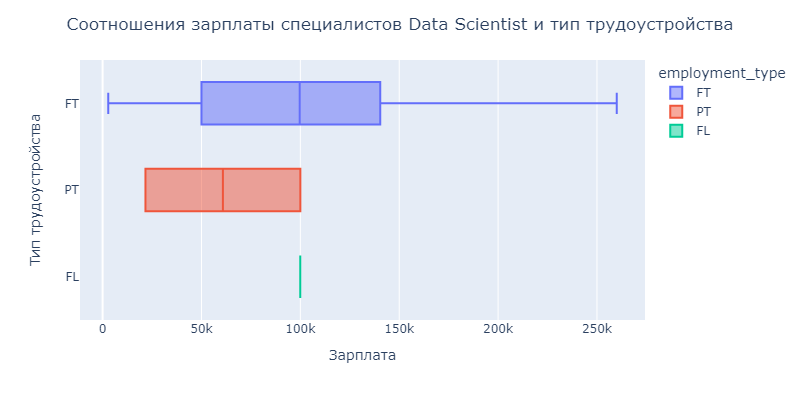

In [141]:
display(temp_ds.groupby('employment_type')['salary_in_usd'].describe().round(2))

fig = px.box(
    temp_ds,
    x='salary_in_usd',
    y='employment_type',
    color='employment_type', 
    width=800, height=400
).update_layout( 
    title={"text": "Cоотношения зарплаты специалистов Data Scientist и тип трудоустройства", "x": 0.5},
    yaxis_title="Тип трудоустройства",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
У нас не достаточно данных по типу трудоустройства "неполный рабочий день" и "фриланс", а по "контракт" вообще нет дынных.
Из этого следует что выводы виляния на трудоустройства на зарплату делать нельзя.
<!-- А также нет смысла проверять критерий "Основная страна проживания сотрудника в течение рабочего года" так как типу трудоустройства "фриланс" всего один. -->


### Проверим как влияет общий объём работы на зарплату

C:\Users\Temnykov\AppData\Local\Temp\ipykernel_7040\3403831889.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,67.0,112073.87,61329.08,5679.0,60412.00,105000.0,159100.0,260000.0


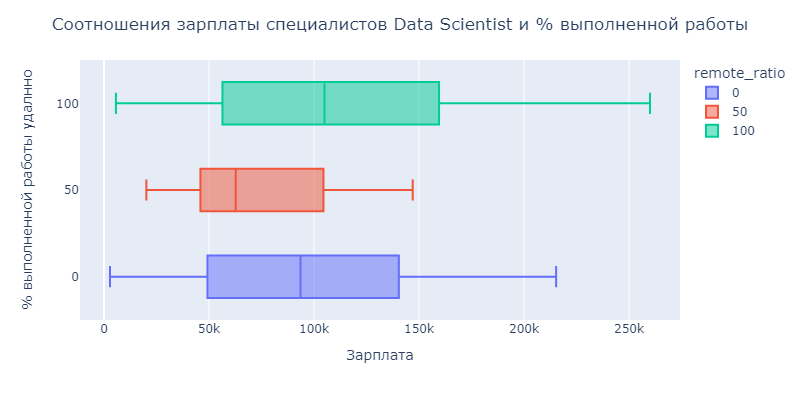

In [142]:
temp_ds['remote_ratio']=temp_ds['remote_ratio'].astype('category')
display(temp_ds.groupby('remote_ratio')['salary_in_usd'].describe().round(2))

fig = px.box(
    temp_ds,
    x='salary_in_usd',
    y='remote_ratio',
    color='remote_ratio', 
    width=800, height=400
).update_layout( 
    title={"text": "Cоотношения зарплаты специалистов Data Scientist и % выполненной работы", "x": 0.5},
    yaxis_title="% выполненной работы удалнно",xaxis_title='Зарплата'
)
if git_bool :fig.show("png")
else: fig.show()

### Вывод
Из графика можно увидеть что полностью удалённая работа или работа в офисе компании оплачивается гораздо выше чем частично удалённая работа из этого можно сделать вывод что у компаний нет предпочтения к смешенной работе.

## Проведем статистический тест чтобы потвердить гипотезу
Что заработная плата выполняемая удаленно на "100%" больше чем зарплата выполняемая не удаленнно "0%"
### Соотношение зарплаты в компаниях среднего размера выше зарплат кпупных компаний?
**Проверка на нормальность**
С помощью теста Левена на равенство дисперсий. Напомним гипотезы теста Левена:        
+ *Нулевая гипотеза* ($H_0$): Нулевая гипотеза обоих тестов утверждает, что дисперсии групп равны.

Проведем сразу тест  Шапиро — Уилка
+ Нулевая: данные распределены нормально.
+ Альтернативная: данные не распределены нормально

Тест на равенство дисперсий
p-value = 0.604
Дисперсии одинаковы, мы можем использовать тест Двухвыборочный t-критерий
p-value = 0.331
Распределение 0 нормальное
p-value = 0.199
Распределение 100 нормальное


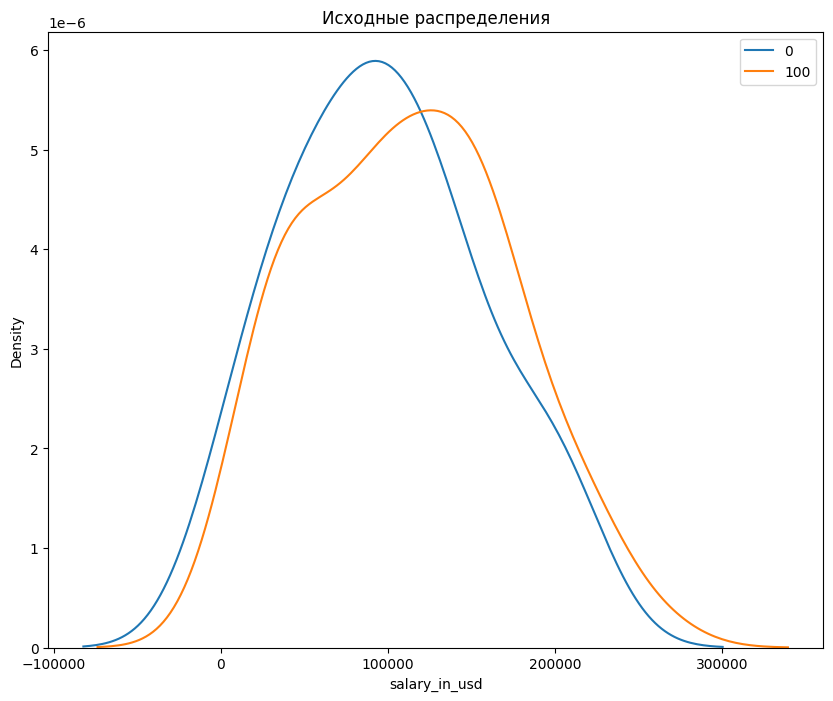

In [143]:
temp_0=temp_ds[temp_ds['remote_ratio']==0]['salary_in_usd']
temp_50=temp_ds[temp_ds['remote_ratio']==50]['salary_in_usd']
temp_100=temp_ds[temp_ds['remote_ratio']==100]['salary_in_usd']

levin_2(temp_0, temp_100, '0', '100')

Выберем подходящий статистический тест

Для выбора нужного теста воспользуемся алгоритмом выбора теста. 
* Для этого ответим на следующие вопросы:
    + Какой тип у признака «Размер заработной платы»? — Количественный.
    + Сколько сравниваемых групп? — 2.
    + Группы зависимы? — Нет.
    + Признак распределён по нормальному закону? — Да.
    
Чтобы проверить нашу гипотезу, Двухвыборочный t-критерий (t-test).
**Сформулируем гипотезы в математическом виде:**        
*Нулевая гипотеза* ($H_0$): размер зарплаты выполняемая на 100% удаленна ($μ_1$) меньше или равна размеру зарплаты рыполняема не удаленно ($μ_2$).        
$$H_0 : μ_1 <= μ_2$$        
*Альтернативная гипотеза* размер зарплаты выполняемая на 100% удаленна ($μ_1$) больше размеру зарплаты выполняема не удаленно ($μ_2$).        
$$ H_1 : μ_1 > μ_2$$

In [144]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(temp_100, temp_0, alternative='greater', equal_var=True)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


Тест на равенство средних
p-value = 0.134
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


### Вывод
Отвергаем альтернативную гипотизу что зарплата выполеной работы удаленно больше чем зарплата работы выполненой в офисе.
### Итого
Можем сказать что работа выполняемая в офисе или полностью удаленно высоко оплачивается, а работа выполняемая на 50% удаленно оплачивается ниже.

### Проверим как сказывается на размер зарплаты соотношение размер компании с выполнением удаленной работы

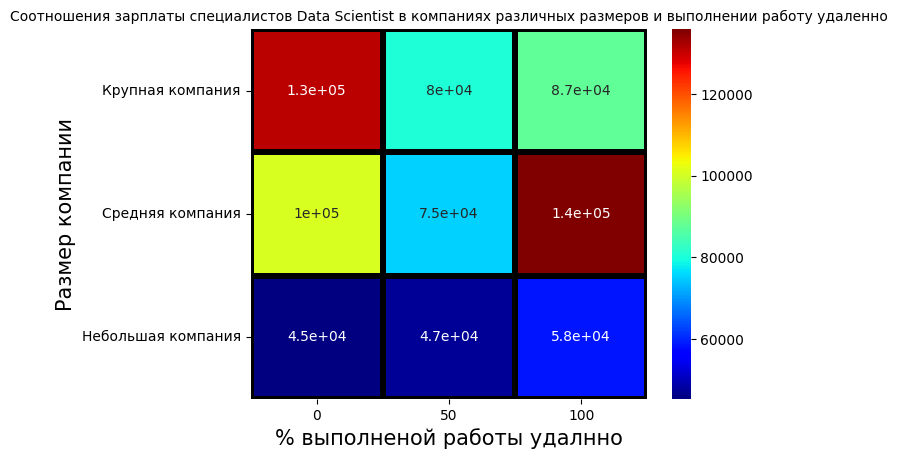

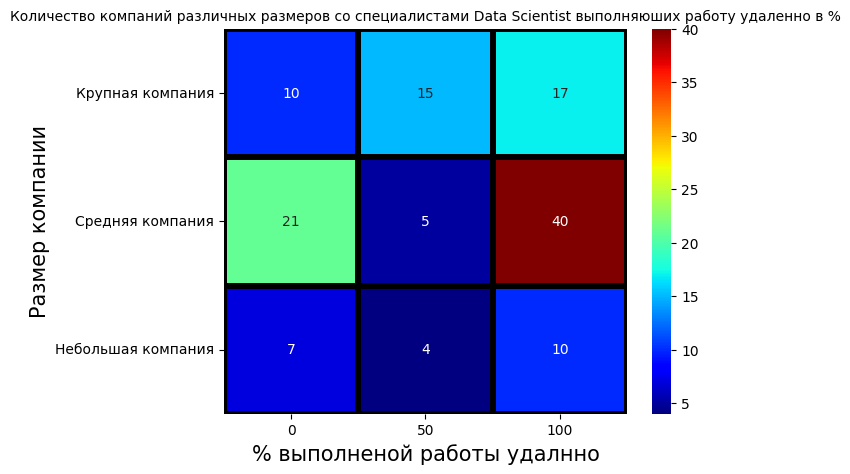

In [145]:
temp_ds_cat['remote_ratio']=temp_ds_cat['remote_ratio'].astype('category')
temp1=temp_ds_cat.pivot_table(
    values='salary_in_usd',   # Значения с которыми производим операции
    index= 'company_size',    # название строк и группировка по значению
    columns= 'remote_ratio',   # название столбцов и группировка по значению
    )

sns.heatmap(temp1, # df
            annot=True, # вывод надписей (подписать фон)
            cmap= 'jet',    # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            linewidths=3, linecolor='black', # толщина и цвет оконтовки ячеек
            ).set_title('Cоотношения зарплаты специалистов Data Scientist в компаниях различных размеров и выполнении работу удаленно', fontsize=10);
plt.ylabel('Размер компании', fontsize = 15)
plt.xlabel('% выполненой работы удалнно', fontsize = 15)


temp2=temp_ds_cat.pivot_table(
    values='salary_in_usd',   # Значения с которыми производим операции
    index= 'company_size',    # название строк и группировка по значению
    columns= 'remote_ratio',   # название столбцов и группировка по значению
    aggfunc='count'      # функция по умолчанию mean()
    )

fig, (ax1) = plt.subplots(ncols=1, figsize=(6.5, 5))
heatmap=sns.heatmap(temp2, # df
            annot=True, # вывод надписей (подписать фон)
            cmap= 'jet',    # палитра цветов  https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
            linewidths=3, linecolor='black', # толщина и цвет оконтовки ячеек
            )
plt.ylabel('Размер компании', fontsize = 15)
plt.xlabel('% выполненой работы удалнно', fontsize = 15)
heatmap.set_title('Количество компаний различных размеров со специалистами Data Scientist выполняюших работу удаленно в %', fontsize=10);

### Вывод
* Из графиков можно сделать вывод
    1. Крупные компании предпочитают оплачивать работу высокой зарплатой непосредственно в офисе компании.
    2. Среднние компании пердпочитают оплачивать работу высокой зарплатой работу удаленно

Итог
При анализе имеющихся данных, а также после проведения статистических тестов, было установлено следующее:

На з.п. влияют следующие факторы:
с увеличением года, наблюдается рост з.п.;
У средних компаний, з.п. оказалась выше чем у крупных;
Увеличение опыта работы также ведет к увеличению з.п.;
По типу занятости ответить затруднительно, т.к. по FL и PT всего 2 сотрудника, и сделать вывод будет нецелесообразно.;
У сотрудников, которые имели более 80% работы удаленно, самая высокая ср. з.п., в то время как у сотрудников с 50%, мин. з.п. выше всех.
После проведения статистических тестов были подтверждены выводы полученные в ходе анализа, а также получены ответы на другие вопросы.
В целом, можно сказать, что почти все факторы, указаные в выборке оказывают влияние на рост з.п. и могут быть рассмотрены.

Итоги
1. Все факторы влияют на зарплату специалиста Data Scientist, но по типу трудоустройства у нас мало данных и мы не можем судить о влиянии типу трудоустройства но зарплату
2. 1. У нас нет оснований отвергать предположения о ежегодном росте зарплат у специалистов Data Scientist.(Да наблюдается)
    2. Зарплаты специалиста Data Scientist и Data Engineer в 2022 году находятся на одинаковом уровне.
    3. Зарплаты специалистов Data Scientist
        + В компаниях средних размеров являются самыми высокими.
        + Зарплата в крупной компании 79% от зарплаты в средней компании
        + Зарплата в небольшая компания 43% от зарплаты в средней компании
    4. Между наличием должностей Data Scientist и Data Engineer и размером компании не наблюдается.
